### 02 - Preparación de datos para modelos de duración de OF

Objetivo: generar un dataset por orden que sirva para predecir `fabricacion_duracion_min` dado `ref_id_str` y `cantidad_lanzada`, incorporando histórico de fases, scrap e incidencias.

**Carga y enriquecimiento de métricas básicas**

Se cargan las OF desde `of_vida.json`, se normalizan fechas y se calculan métricas clave por orden (scrap, yield, duración por unidad, incidencias en horas).

In [8]:

import pandas as pd
import re
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 200)

PROCESSED = Path('../../data/processed')
PATH_JSON = PROCESSED / 'of_vida.json'

vida = pd.read_json(PATH_JSON)
for c in ['primera_fase_ts', 'ultima_fase_ts']:
    vida[c] = pd.to_datetime(vida[c], errors='coerce')

suma_ok_scrap = vida['cantidad_final_ok'] + vida['scrap_total']
vida['scrap_rate'] = vida['scrap_total'] / suma_ok_scrap.replace({0: pd.NA})
vida['yield_ok'] = vida['cantidad_final_ok'] / vida['cantidad_lanzada'].replace({0: pd.NA})
vida['fabricacion_dias'] = vida['fabricacion_duracion_min'] / 1440
vida['incidencias_horas'] = vida['incidencias_duracion_total'] / 60
vida['duracion_min_por_ud'] = vida['fabricacion_duracion_min'] / vida['cantidad_lanzada'].replace({0: pd.NA})

print(f"Órdenes: {len(vida)}")
print(f"Referencias distintas: {vida['ref_id_str'].nunique()}")
vida.head(3)


Órdenes: 137
Referencias distintas: 31


,work_order_id,ref_id_str,cantidad_lanzada,operaciones,cantidad_final_ok,scrap_total,tiempo_total_min,primera_fase_ts,ultima_fase_ts,fabricacion_duracion_min,incidencias_duracion_total,scrap_rate,yield_ok,fabricacion_dias,incidencias_horas,duracion_min_por_ud
0,24/0712,031100,9753,"[{'op': 'CURVADO-CORT', 'piezas_lanzadas': 975...",9620,133,32153,2025-01-07 02:03:00,2025-01-23 00:26:00,22943,1589,0.013637,0.986363,15.932639,26.483333,2.352404
1,24/0722,008091,2596,"[{'op': 'CURVADO-CORT', 'piezas_lanzadas': 259...",2525,71,11508,2025-01-16 06:54:00,2025-02-07 15:01:00,32167,1929,0.027350,0.972650,22.338194,32.150000,12.390986
2,24/0728,092901,1000,"[{'op': 'CURVADO-CORT', 'piezas_lanzadas': 100...",953,47,3435,2025-01-08 16:17:00,2025-04-07 13:54:00,128017,438,0.047000,0.953000,88.900694,7.300000,128.017000


**Referencias con más histórico y duración típica**

Resumen de nº de OF por referencia, mediana de duración de fabricación y visualizaciones rápidas para ver variabilidad entre referencias y el efecto de la cantidad lanzada.

Top referencias por nº de órdenes:


,ref_id_str,n_of
0,124203,19
1,031100,14
2,081290,11
3,081303,10
4,902081,9
5,081906,8
6,081GJ1,7
7,086503,7
8,091177,6
9,081216,6


Mediana de duración de fabricación (min) por referencia:


ref_id_str
913600    183114.0
092901    128017.0
818500    124496.0
003800    123099.0
003304    110973.0
081803     99440.0
190301     74769.0
081602     71901.0
081000     71129.0
091135     63438.5
Name: fabricacion_duracion_min, dtype: float64

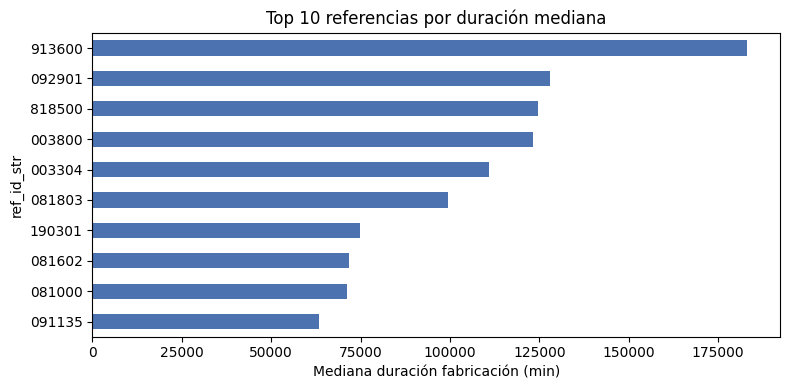

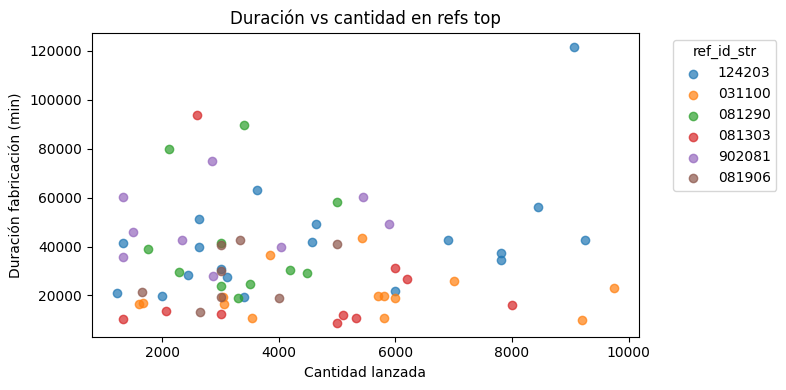

In [9]:

# Recuento de OF por referencia
refs = (vida['ref_id_str']
        .value_counts()
        .rename_axis('ref_id_str')
        .reset_index(name='n_of'))
print('Top referencias por nº de órdenes:')
display(refs.head(10))

# Mediana de duración por referencia
med_dur = (vida.groupby('ref_id_str')['fabricacion_duracion_min']
           .median()
           .sort_values(ascending=False))
print('Mediana de duración de fabricación (min) por referencia:')
display(med_dur.head(10))

# Plot: medianas top 10
plt.figure(figsize=(8, 4))
med_dur.head(10).sort_values().plot(kind='barh', color='#4C72B0')
plt.xlabel('Mediana duración fabricación (min)')
plt.ylabel('ref_id_str')
plt.title('Top 10 referencias por duración mediana')
plt.tight_layout()
plt.show()

# Plot: duración vs cantidad lanzada para refs con más histórico
refs_top = refs.head(6)['ref_id_str'].tolist()
subset = vida[vida['ref_id_str'].isin(refs_top)]
plt.figure(figsize=(8, 4))
for ref in refs_top:
    g = subset[subset['ref_id_str'] == ref]
    plt.scatter(g['cantidad_lanzada'], g['fabricacion_duracion_min'], label=ref, alpha=0.7)
plt.xlabel('Cantidad lanzada')
plt.ylabel('Duración fabricación (min)')
plt.title('Duración vs cantidad en refs top')
plt.legend(title='ref_id_str', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Calculadora rápida de ciclo por referencia**

Heurística simple: sumar duración total y unidades buenas fabricadas por referencia para estimar un tiempo medio por unidad. Imprime referencias disponibles y calcula ciclo medio para una referencia objetivo (editable).

In [10]:

# Calculadora de ciclo medio por referencia
ref_objetivo = '124203'  

# Agregados por referencia
agg_ref = (vida.groupby('ref_id_str')
           .agg(
               of_count=('work_order_id', 'count'),
               uds_ok=('cantidad_final_ok', 'sum'),
               dur_total_min=('fabricacion_duracion_min', 'sum')
           ))
agg_ref['ciclo_min_por_ud'] = agg_ref['dur_total_min'] / agg_ref['uds_ok'].replace({0: pd.NA})
agg_ref = agg_ref.sort_values('ciclo_min_por_ud')

print('Referencias disponibles:', ', '.join(agg_ref.index.tolist()))
print('Top 5 ciclos medios más rápidos (min/ud):')
display(agg_ref[['ciclo_min_por_ud']].head(5))

if ref_objetivo in agg_ref.index:
    fila = agg_ref.loc[ref_objetivo]
    print(f"Referencia objetivo: {ref_objetivo}")
    print(f"OFs: {fila['of_count']:.0f} | Uds OK: {fila['uds_ok']:.0f} | Dur total (min): {fila['dur_total_min']:.0f}")
    print(f"Ciclo medio estimado: {fila['ciclo_min_por_ud']:.2f} min/ud")
else:
    print(f"Referencia {ref_objetivo} no encontrada. Usa una de las disponibles.")


Referencias disponibles: 031100, 081147, 086503, 091503, 081303, 081103, 091135, 081GJ1, 124203, 081906, 081216, 904802, 091700, 091177, 008091, 081290, 081806, 081901, 902081, 091232, 081803, 081910, 081602, 009400, 081000, 003800, 003304, 190301, 913600, 092901, 818500
Top 5 ciclos medios más rápidos (min/ud):


,ciclo_min_por_ud
ref_id_str,
031100,4.073768
081147,4.216124
086503,4.697177
091503,5.254915
081303,5.378961


Referencia objetivo: 124203
OFs: 19 | Uds OK: 88150 | Dur total (min): 790337
Ciclo medio estimado: 8.97 min/ud


**Explosión de operaciones**

Se desanida la lista de fases/operaciones por OF para contar fases, secuencias y duraciones individuales por fase.

In [11]:

ops_exp = (vida[['work_order_id', 'ref_id_str', 'cantidad_lanzada', 'operaciones']]
           .explode('operaciones')
           .dropna(subset=['operaciones'])
           .reset_index(drop=True))

ops_norm = pd.json_normalize(ops_exp['operaciones'])
ops_df = pd.concat([ops_exp[['work_order_id', 'ref_id_str', 'cantidad_lanzada']], ops_norm], axis=1)
ops_df['orden_op'] = ops_df.groupby('work_order_id').cumcount()

print('Registros de operación:', ops_df.shape)
print('Catálogo de operaciones:')
display(ops_df['op'].value_counts())
ops_df.head(5)


Registros de operación: (1047, 9)
Catálogo de operaciones:


op
CURVADO-CORT    136
SOLDADURA-RE    135
GRANALLADO      135
NORMALIZADO     134
TALLADO         134
CALIBRADO       133
RECTIFICADO     133
TEMPLE-REVEN     46
ENTRADA DE D     38
TORNEADO         15
TEMPLAR POR       2
SOLDAR-REBAB      1
CURVAR-CORTA      1
CALIBRAR FRI      1
TALLAR            1
SACAR ENTRAD      1
APLANADO          1
Name: count, dtype: int64

,work_order_id,ref_id_str,cantidad_lanzada,op,piezas_lanzadas,salida_estimada,piezas_scrap,duracion_min,orden_op
0,24/0712,031100,9753,CURVADO-CORT,9753.0,9723.0,30.0,1565.0,0
1,24/0712,031100,9753,SOLDADURA-RE,9723.0,9707.0,16.0,3340.0,1
2,24/0712,031100,9753,NORMALIZADO,9707.0,9707.0,0.0,1026.0,2
3,24/0712,031100,9753,GRANALLADO,9707.0,9707.0,0.0,1028.0,3
4,24/0712,031100,9753,CALIBRADO,9707.0,9707.0,0.0,1299.0,4


**Features agregados por OF**

Se construyen features de operaciones: nº de fases, duración total, scrap total, secuencia de fases y duración/scrap por fase (totales y normalizados por unidad).

In [12]:


def slug(texto: str) -> str:
    """Convierte nombres de operación en identificadores seguros para columnas."""
    return re.sub(r'[^0-9a-zA-Z]+', '_', str(texto)).strip('_').lower()

ordenado = ops_df.sort_values(['work_order_id', 'orden_op'])
op_seq = ordenado.groupby('work_order_id')['op'].agg(' > '.join)

op_summary = (ops_df.groupby('work_order_id')
              .agg(
                  ops_count=('op', 'count'),
                  ops_unique=('op', 'nunique'),
                  duracion_ops_min=('duracion_min', 'sum'),
                  scrap_ops_total=('piezas_scrap', 'sum'),
              )
              .join(op_seq))

op_duration = (ops_df.pivot_table(index='work_order_id', columns='op', values='duracion_min', aggfunc='sum')
               .rename(columns=lambda c: f"dur_min_{slug(c)}"))

op_duration_per_ud = op_duration.div(ops_df.groupby('work_order_id')['cantidad_lanzada'].first(), axis=0)
op_duration_per_ud = op_duration_per_ud.rename(columns=lambda c: f"{c}_por_ud")

op_scrap = (ops_df.pivot_table(index='work_order_id', columns='op', values='piezas_scrap', aggfunc='sum')
            .rename(columns=lambda c: f"scrap_{slug(c)}"))

op_features = op_summary.join([op_duration, op_duration_per_ud, op_scrap])
print('Shape features por OF:', op_features.shape)
op_features.head(3)


Shape features por OF: (137, 56)


,ops_count,ops_unique,duracion_ops_min,scrap_ops_total,op,dur_min_aplanado,dur_min_calibrado,dur_min_calibrar_fri,dur_min_curvado_cort,dur_min_curvar_corta,dur_min_entrada_de_d,dur_min_granallado,dur_min_normalizado,dur_min_rectificado,dur_min_sacar_entrad,dur_min_soldadura_re,dur_min_soldar_rebab,dur_min_tallado,dur_min_tallar,dur_min_templar_por,dur_min_temple_reven,dur_min_torneado,dur_min_aplanado_por_ud,dur_min_calibrado_por_ud,dur_min_calibrar_fri_por_ud,dur_min_curvado_cort_por_ud,dur_min_curvar_corta_por_ud,dur_min_entrada_de_d_por_ud,dur_min_granallado_por_ud,dur_min_normalizado_por_ud,dur_min_rectificado_por_ud,dur_min_sacar_entrad_por_ud,dur_min_soldadura_re_por_ud,dur_min_soldar_rebab_por_ud,dur_min_tallado_por_ud,dur_min_tallar_por_ud,dur_min_templar_por_por_ud,dur_min_temple_reven_por_ud,dur_min_torneado_por_ud,scrap_aplanado,scrap_calibrado,scrap_calibrar_fri,scrap_curvado_cort,scrap_curvar_corta,scrap_entrada_de_d,scrap_granallado,scrap_normalizado,scrap_rectificado,scrap_sacar_entrad,scrap_soldadura_re,scrap_soldar_rebab,scrap_tallado,scrap_tallar,scrap_templar_por,scrap_temple_reven,scrap_torneado
work_order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24/0712,8,8,32153.0,133.0,CURVADO-CORT > SOLDADURA-RE > NORMALIZADO > GR...,NaN,1299.0,NaN,1565.0,NaN,6124.0,1028.0,1026.0,5604.0,NaN,3340.0,NaN,12167.0,NaN,NaN,NaN,NaN,NaN,0.133190,NaN,0.160463,NaN,0.627909,0.105403,0.105198,0.574592,NaN,0.342459,NaN,1.247514,NaN,NaN,NaN,NaN,NaN,0.0,NaN,30.0,NaN,21.0,0.0,0.0,44.0,NaN,16.0,NaN,22.0,NaN,NaN,NaN,NaN
24/0722,8,8,11508.0,71.0,CURVADO-CORT > SOLDADURA-RE > NORMALIZADO > GR...,NaN,783.0,NaN,368.0,NaN,NaN,395.0,395.0,2109.0,NaN,953.0,NaN,4472.0,NaN,NaN,2033.0,NaN,NaN,0.301618,NaN,0.141757,NaN,NaN,0.152157,0.152157,0.812404,NaN,0.367103,NaN,1.722650,NaN,NaN,0.783128,NaN,NaN,0.0,NaN,8.0,NaN,NaN,0.0,0.0,13.0,NaN,9.0,NaN,35.0,NaN,NaN,6.0,NaN
24/0728,5,5,3435.0,47.0,CURVADO-CORT > SOLDADURA-RE > GRANALLADO > CAL...,NaN,609.0,NaN,710.0,NaN,NaN,149.0,NaN,NaN,NaN,699.0,NaN,NaN,NaN,NaN,NaN,1268.0,NaN,0.609000,NaN,0.710000,NaN,NaN,0.149000,NaN,NaN,NaN,0.699000,NaN,NaN,NaN,NaN,NaN,1.268,NaN,0.0,NaN,33.0,NaN,NaN,0.0,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,0.0


**Dataset final para modelado**

Se juntan métricas base de la OF con las features de operaciones, se define `y_fabricacion_min` como target y se guarda el CSV preparado.

In [13]:

cols_drop = ['operaciones']
base = vida.drop(columns=[c for c in cols_drop if c in vida.columns])

vida_model = (base
              .merge(op_features, on='work_order_id', how='left')
              .sort_values('work_order_id')
              .reset_index(drop=True))

data_model = vida_model.rename(columns={'fabricacion_duracion_min': 'y_fabricacion_min'})

OUTPUT = PROCESSED / 'of_vida_model_ready.csv'
data_model.to_csv(OUTPUT, index=False)

print('Dataset final para modelado:', data_model.shape)
print('Guardado en:', OUTPUT)
data_model.head(5)


Dataset final para modelado: (137, 71)
Guardado en: ../../data/processed/of_vida_model_ready.csv


,work_order_id,ref_id_str,cantidad_lanzada,cantidad_final_ok,scrap_total,tiempo_total_min,primera_fase_ts,ultima_fase_ts,y_fabricacion_min,incidencias_duracion_total,scrap_rate,yield_ok,fabricacion_dias,incidencias_horas,duracion_min_por_ud,ops_count,ops_unique,duracion_ops_min,scrap_ops_total,op,dur_min_aplanado,dur_min_calibrado,dur_min_calibrar_fri,dur_min_curvado_cort,dur_min_curvar_corta,dur_min_entrada_de_d,dur_min_granallado,dur_min_normalizado,dur_min_rectificado,dur_min_sacar_entrad,dur_min_soldadura_re,dur_min_soldar_rebab,dur_min_tallado,dur_min_tallar,dur_min_templar_por,dur_min_temple_reven,dur_min_torneado,dur_min_aplanado_por_ud,dur_min_calibrado_por_ud,dur_min_calibrar_fri_por_ud,dur_min_curvado_cort_por_ud,dur_min_curvar_corta_por_ud,dur_min_entrada_de_d_por_ud,dur_min_granallado_por_ud,dur_min_normalizado_por_ud,dur_min_rectificado_por_ud,dur_min_sacar_entrad_por_ud,dur_min_soldadura_re_por_ud,dur_min_soldar_rebab_por_ud,dur_min_tallado_por_ud,dur_min_tallar_por_ud,dur_min_templar_por_por_ud,dur_min_temple_reven_por_ud,dur_min_torneado_por_ud,scrap_aplanado,scrap_calibrado,scrap_calibrar_fri,scrap_curvado_cort,scrap_curvar_corta,scrap_entrada_de_d,scrap_granallado,scrap_normalizado,scrap_rectificado,scrap_sacar_entrad,scrap_soldadura_re,scrap_soldar_rebab,scrap_tallado,scrap_tallar,scrap_templar_por,scrap_temple_reven,scrap_torneado
0,24/0712,031100,9753,9620,133,32153,2025-01-07 02:03:00,2025-01-23 00:26:00,22943,1589,0.013637,0.986363,15.932639,26.483333,2.352404,8,8,32153.0,133.0,CURVADO-CORT > SOLDADURA-RE > NORMALIZADO > GR...,NaN,1299.0,NaN,1565.0,NaN,6124.0,1028.0,1026.0,5604.0,NaN,3340.0,NaN,12167.0,NaN,NaN,NaN,NaN,NaN,0.133190,NaN,0.160463,NaN,0.627909,0.105403,0.105198,0.574592,NaN,0.342459,NaN,1.247514,NaN,NaN,NaN,NaN,NaN,0.0,NaN,30.0,NaN,21.0,0.0,0.0,44.0,NaN,16.0,NaN,22.0,NaN,NaN,NaN,NaN
1,24/0722,008091,2596,2525,71,11508,2025-01-16 06:54:00,2025-02-07 15:01:00,32167,1929,0.027350,0.972650,22.338194,32.150000,12.390986,8,8,11508.0,71.0,CURVADO-CORT > SOLDADURA-RE > NORMALIZADO > GR...,NaN,783.0,NaN,368.0,NaN,NaN,395.0,395.0,2109.0,NaN,953.0,NaN,4472.0,NaN,NaN,2033.0,NaN,NaN,0.301618,NaN,0.141757,NaN,NaN,0.152157,0.152157,0.812404,NaN,0.367103,NaN,1.722650,NaN,NaN,0.783128,NaN,NaN,0.0,NaN,8.0,NaN,NaN,0.0,0.0,13.0,NaN,9.0,NaN,35.0,NaN,NaN,6.0,NaN
2,24/0728,092901,1000,953,47,3435,2025-01-08 16:17:00,2025-04-07 13:54:00,128017,438,0.047000,0.953000,88.900694,7.300000,128.017000,5,5,3435.0,47.0,CURVADO-CORT > SOLDADURA-RE > GRANALLADO > CAL...,NaN,609.0,NaN,710.0,NaN,NaN,149.0,NaN,NaN,NaN,699.0,NaN,NaN,NaN,NaN,NaN,1268.0,NaN,0.609000,NaN,0.710000,NaN,NaN,0.149000,NaN,NaN,NaN,0.699000,NaN,NaN,NaN,NaN,NaN,1.268000,NaN,0.0,NaN,33.0,NaN,NaN,0.0,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,0.0
3,24/0733,124203,9247,9149,98,41450,2025-01-09 07:35:00,2025-02-07 20:44:00,42549,5448,0.010598,0.989402,29.547917,90.800000,4.601384,8,8,41450.0,98.0,CURVADO-CORT > SOLDADURA-RE > NORMALIZADO > GR...,NaN,4356.0,NaN,1853.0,NaN,NaN,1394.0,1391.0,8580.0,NaN,3938.0,NaN,12805.0,NaN,NaN,NaN,7133.0,NaN,0.471072,NaN,0.200389,NaN,NaN,0.150752,0.150427,0.927868,NaN,0.425868,NaN,1.384773,NaN,NaN,NaN,0.771385,NaN,2.0,NaN,0.0,NaN,NaN,0.0,0.0,47.0,NaN,12.0,NaN,20.0,NaN,NaN,NaN,17.0
4,24/0734,124203,2639,2614,25,11135,2025-01-15 12:09:00,2025-02-20 05:58:00,51469,1388,0.009473,0.990527,35.742361,23.133333,19.503221,8,8,11135.0,25.0,CURVADO-CORT > SOLDADURA-RE > NORMALIZADO > GR...,NaN,612.0,NaN,755.0,NaN,NaN,394.0,395.0,2778.0,NaN,956.0,NaN,2946.0,NaN,NaN,NaN,2299.0,NaN,0.231906,NaN,0.286093,NaN,NaN,0.149299,0.149678,1.052671,NaN,0.362258,NaN,1.116332,NaN,NaN,NaN,0.871163,NaN,0.0,NaN,6.0,NaN,NaN,0.0,0.0,13.0,NaN,5.0,NaN,1.0,NaN,NaN,NaN,0.0
